In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [3]:
# API URL
url_KRX = "http://data-dbg.krx.co.kr/svc/apis/idx/krx_dd_trd"
# 인증키 설정
auth_key = "956087495A1D4769A88B0F3411D0890EF02445EB"
# 헤더작성
headers = {"AUTH_KEY": auth_key,}

In [4]:
def get_monthly_data(year, month, whatKRX):
    # 시작일과 종료일 계산
    start_date = datetime(year, month, 1)
    if month == 12:
        end_date = datetime(year + 1, 1, 1) - timedelta(days=1)
    else:
        end_date = datetime(year, month + 1, 1) - timedelta(days=1)

    all_data = []
    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime("%Y%m%d")
        params_KRX = {"basDd": date_str}
        response_KRX = requests.get(url_KRX, headers=headers, params=params_KRX)

        if response_KRX.status_code == 200:
            data = response_KRX.json()
            if 'OutBlock_1' in data and data['OutBlock_1']:  # 데이터가 존재하는지 확인
                df = pd.DataFrame(data['OutBlock_1'])
                all_data.append(df)
        else:
            print(f"Error {response_KRX.status_code} on {date_str}: {response_KRX.text}")

        current_date += timedelta(days=1)

    if all_data:
        monthly_df = pd.concat(all_data, ignore_index=True)
        monthly_df = monthly_df.rename(columns={
        'BAS_DD': '기준일자',
        'IDX_CLSS': '계열구분',
        'IDX_NM': '지수명',
        'CLSPRC_IDX': '종가',
        'CMPPREVDD_IDX': '대비',
        'FLUC_RT': '등락률',
        'OPNPRC_IDX': '시가',
        'HGPRC_IDX': '고가',
        'LWPRC_IDX': '저가',
        'ACC_TRDVOL': '거래량',
        'ACC_TRDVAL': '거래대금',
        'MKTCAP': '상장시가총액'
        })
        monthly_df = monthly_df[monthly_df['지수명'] == whatKRX]
        monthly_df = monthly_df.reset_index(drop=True)
        return monthly_df
    else:
        return None

In [5]:
def get_yearly_data(year,whatKRX):
    all_data = []
    for month in range(1, 13):
        start_date = datetime(year, month, 1)
        if month == 12:
            end_date = datetime(year + 1, 1, 1) - timedelta(days=1)
        else:
            end_date = datetime(year, month + 1, 1) - timedelta(days=1)

        current_date = start_date
        while current_date <= end_date:
            date_str = current_date.strftime("%Y%m%d")
            params_KRX = {"basDd": date_str}
            response_KRX = requests.get(url_KRX, headers=headers, params=params_KRX)

            if response_KRX.status_code == 200:
                data = response_KRX.json()
                if 'OutBlock_1' in data and data['OutBlock_1']:
                    df = pd.DataFrame(data['OutBlock_1'])
                    all_data.append(df)
            else:
                print(f"Error {response_KRX.status_code} on {date_str}: {response_KRX.text}")

            current_date += timedelta(days=1)

    if all_data:
        yearly_df = pd.concat(all_data, ignore_index=True)
        yearly_df = yearly_df.rename(columns={
        'BAS_DD': '기준일자',
        'IDX_CLSS': '계열구분',
        'IDX_NM': '지수명',
        'CLSPRC_IDX': '종가',
        'CMPPREVDD_IDX': '대비',
        'FLUC_RT': '등락률',
        'OPNPRC_IDX': '시가',
        'HGPRC_IDX': '고가',
        'LWPRC_IDX': '저가',
        'ACC_TRDVOL': '거래량',
        'ACC_TRDVAL': '거래대금',
        'MKTCAP': '상장시가총액'
        })
        yearly_df = yearly_df[yearly_df['지수명'] == whatKRX]
        yearly_df = yearly_df.reset_index(drop=True)
        return yearly_df
    else:
        return None

In [6]:
money_2023_df = get_yearly_data(2023, 'KRX 300 금융')

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [8]:
def PRC(df):
    df_copy = df.copy()

    # '기준일자' 컬럼을 datetime 객체로 변환
    # 전처리가 된 상태에서 해야됨.
    df_copy['기준일자'] = pd.to_datetime(df_copy['기준일자'])

    df_copy['시가'] = df_copy['시가'].astype(float)
    df_copy['고가'] = df_copy['고가'].astype(float)
    df_copy['저가'] = df_copy['저가'].astype(float)

    df_copy = df_copy.set_index('기준일자')

    plt.figure(figsize=(12, 6))  # 그래프 크기 조절
    plt.plot(df_copy['시가'], label='OPN PRC')
    plt.plot(df_copy['고가'], label='HI PRC')
    plt.plot(df_copy['저가'], label='LW PRC')

    plt.title('KRX')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)

    # Y축 눈금 간격을 5분위로 제한
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))

    plt.show()

In [9]:
def ACC(df):
    df_copy = df.copy()

    # '기준일자' 컬럼을 datetime 객체로 변환
    # 전처리가 된 상태에서 해야됨.
    df_copy['기준일자'] = pd.to_datetime(df_copy['기준일자'])

    df_copy['거래량'] = df_copy['거래량'].astype(float)
    df_copy['거래대금'] = df_copy['거래대금'].astype(float)

    df_copy = df_copy.set_index('기준일자')

    acc = [['거래량','ACC_TRDVOL'],['거래대금','ACC_TRDVAL']]
    for i in acc:
        plt.figure(figsize=(12, 6))  # 그래프 크기 조절
        plt.plot(df_copy[i[0]], label=i[1])

        plt.title(i[1])
        plt.xlabel('Date')
        plt.ylabel('Values')
        plt.legend()
        plt.grid(True)

        # Y축 눈금 간격을 5분위로 제한
        plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))

        plt.show()

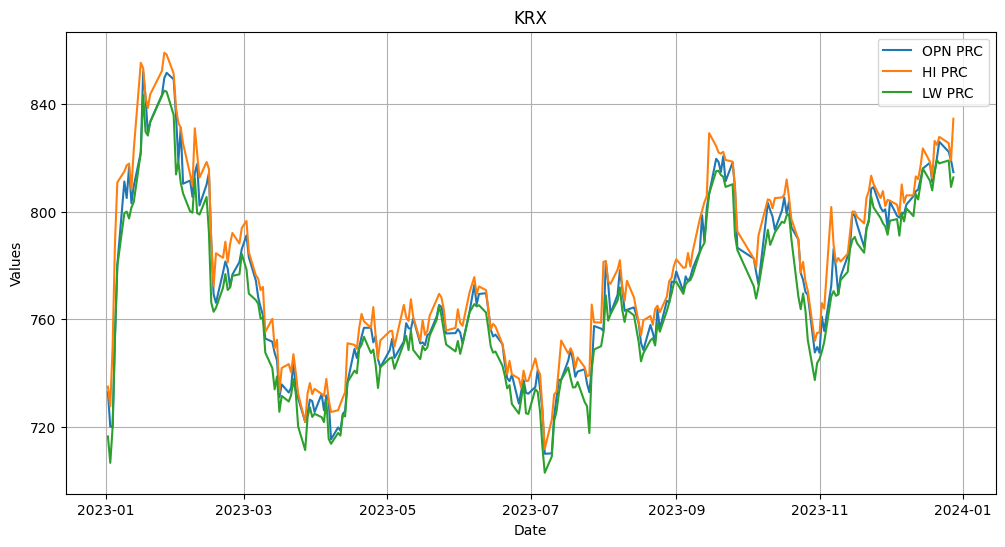

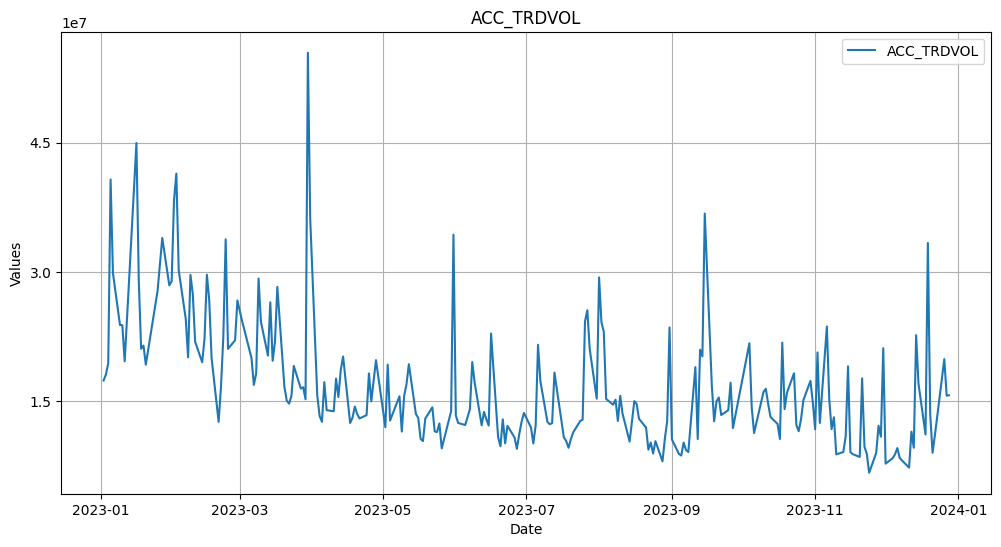

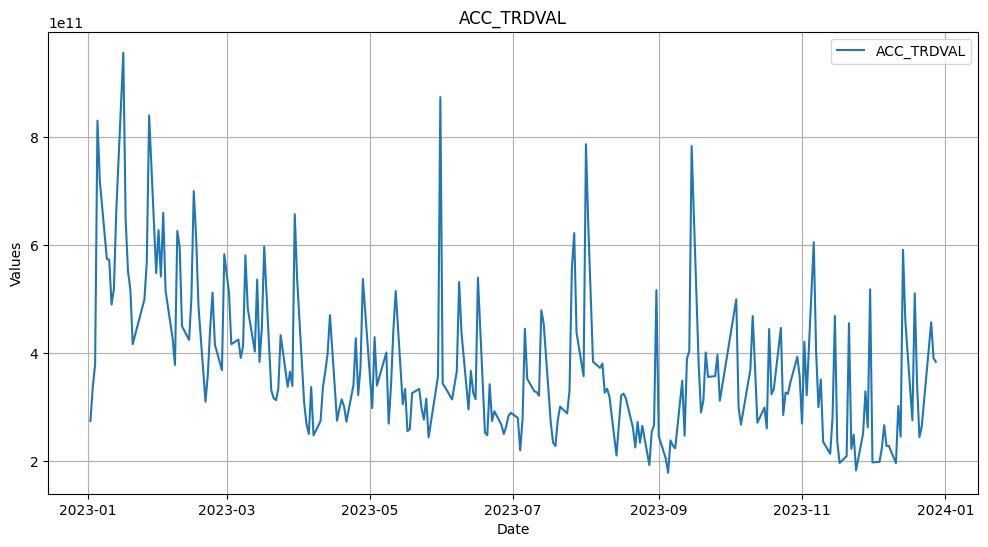

In [ ]:
PRC(money_2023_df)
ACC(money_2023_df)

In [10]:
# 전날 대비 비율 계산 함수
def calculate_ratio(today, yesterday):
    if yesterday == 0:
        return 0
    else:
        return today / yesterday

def setRatio(df, newName, whatCol):
    df[whatCol] = pd.to_numeric(df[whatCol], errors='coerce').fillna(0)
    for i in range(1, len(df)):
        df.loc[i, newName] = calculate_ratio(df.loc[i, whatCol], df.loc[i - 1, whatCol])

In [11]:
def calculateNextDay(df, whatCol):
    df[whatCol] = pd.to_numeric(df[whatCol], errors='coerce').fillna(0)
    strNext = '다음날' + whatCol
    df[strNext] = 0
    for i in range(len(df) - 1):
        today_close = df.loc[i, whatCol]
        next_day_close = df.loc[i+1, whatCol]
        df.loc[i, strNext] = 1 if next_day_close > today_close else 0

In [12]:
def calculateDifferent(df, whatCol1, whatCol2):
    df[whatCol1] = pd.to_numeric(df[whatCol1], errors='coerce').fillna(0)
    df[whatCol2] = pd.to_numeric(df[whatCol2], errors='coerce').fillna(0)
    strNext = whatCol1 + '와' + whatCol2 + '차이'
    df[strNext] = 0.0
    for i in range(len(df)):
        df.loc[i, strNext] = abs(df.loc[i, whatCol1] - df.loc[i, whatCol2])

In [14]:
columns_to_convert = ['거래량', '거래대금', '시가', '고가', '저가', '종가']
for col in columns_to_convert:
    strRatio = '전날대비' + col + '비율'
    setRatio(money_2023_df, strRatio, col)

In [15]:
columns_to_next = ['종가','거래량','거래대금']
for col in columns_to_next:
    calculateNextDay(money_2023_df, col)

In [16]:
calculateDifferent(money_2023_df, '시가','고가')
calculateDifferent(money_2023_df, '시가','저가')
calculateDifferent(money_2023_df, '종가','고가')
calculateDifferent(money_2023_df, '종가','저가')

In [13]:
pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.2/254.2 kB 15.3 MB/s eta 0:00:00


In [17]:
from pykrx import stock

In [18]:
# 시작일과 종료일 설정
start_date = "2023-01-01"
end_date = "2023-12-31"

# 코스피 지수 데이터를 가져와 데이터프레임으로 저장
kospi_index = stock.get_index_ohlcv_by_date(start_date, end_date, "1001")[['종가']].dropna()

In [19]:
kospi_index.index = money_2023_df.index
money_2023_df['KOSPI종가'] = kospi_index

In [20]:
def setMoneyRatio(df, newName, whatCol):
    df[whatCol] = pd.to_numeric(df[whatCol], errors='coerce').fillna(0)
    for i in range(1, len(df)):
        df.loc[i, newName] = calculate_ratio(df.loc[i, whatCol]- df.loc[i - 1, whatCol], df.loc[i - 1, whatCol])

In [21]:
setMoneyRatio(money_2023_df, 'KOSPI지수월간수익률', 'KOSPI종가')
setMoneyRatio(money_2023_df, '월간수익률', '종가')

In [23]:
# 공분산
covariance = money_2023_df['월간수익률'].cov(money_2023_df['KOSPI지수월간수익률'])

# 분산
variance = np.var(money_2023_df['KOSPI지수월간수익률'])

# 베타
beta = covariance / variance

print("베타:", beta)

베타: 0.7703685116604451


In [24]:
money_2023_df.dropna(subset=['전날대비거래량비율','기준일자'], inplace=True)

#Alternatively, if you want to remove rows with ANY NaN values in the entire dataframe
#money_2023_df.dropna(inplace=True)

money_2023_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 1 to 244
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   기준일자          244 non-null    object 
 1   계열구분          244 non-null    object 
 2   지수명           244 non-null    object 
 3   종가            244 non-null    float64
 4   대비            244 non-null    object 
 5   등락률           244 non-null    object 
 6   시가            244 non-null    float64
 7   고가            244 non-null    float64
 8   저가            244 non-null    float64
 9   거래량           244 non-null    int64  
 10  거래대금          244 non-null    int64  
 11  상장시가총액        244 non-null    object 
 12  전날대비거래량비율     244 non-null    float64
 13  전날대비거래대금비율    244 non-null    float64
 14  전날대비시가비율      244 non-null    float64
 15  전날대비고가비율      244 non-null    float64
 16  전날대비저가비율      244 non-null    float64
 17  전날대비종가비율      244 non-null    float64
 18  다음날종가         244 non-null    int64

In [ ]:
columns_to_drop = ['계열구분', '지수명', '종가', '대비', '등락률', '시가', '고가', '저가', '거래량', '거래대금', '상장시가총액']
money_2023_df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

In [ ]:
money_2023_df.head()

,기준일자,전날대비거래량비율,전날대비거래대금비율,전날대비시가비율,전날대비고가비율,전날대비저가비율,전날대비종가비율,다음날종가,다음날거래량,다음날거래대금,시가와고가차이,시가와저가차이,종가와고가차이,종가와저가차이
1,20230103,1.039917,1.231009,0.982615,0.990013,0.986320,1.011475,1,1,1,7.53,13.49,3.00,18.02
2,20230104,1.072259,1.125510,0.999931,1.030361,1.018696,1.034433,1,1,1,29.67,0.23,0.14,29.76
3,20230105,2.095560,2.192336,1.046208,1.051529,1.046542,1.048163,1,0,0,35.03,0.00,2.67,32.36
4,20230106,0.733829,0.865096,1.035790,1.028605,1.035100,1.024922,1,0,0,30.62,0.52,5.64,25.50
5,20230109,0.798377,0.799210,1.039680,1.005032,1.025253,1.004285,1,0,0,3.74,11.79,6.27,9.26


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# 정규화할 컬럼 선택 (기준일자 제외)
columns_to_normalize = [col for col in money_2023_df.columns if col != '기준일자']

# 숫자형 데이터만 정규화
numeric_cols = money_2023_df[columns_to_normalize].select_dtypes(include=['number'])

# 정규화 수행
normalized_data = scaler.fit_transform(numeric_cols)

# 정규화된 데이터를 DataFrame으로 변환
normalized_df = pd.DataFrame(normalized_data, columns=numeric_cols.columns)

# 기준일자 컬럼을 다시 추가
normalized_df['기준일자'] = money_2023_df['기준일자']
normalized_df.dropna(subset='기준일자', inplace=True)

In [ ]:
# prompt: 'money_2023_df'의 '다음날 종가' 컬럼을 맨 뒤로 옮기고 싶습니다.

# '다음날 종가' 컬럼을 맨 뒤로 이동
cols = list(money_2023_df.columns)
cols.remove('다음날종가')
cols.append('다음날종가')
money_2023_df = money_2023_df[cols]

In [ ]:
money_2023_df.head(3)

,기준일자,전날대비거래량비율,전날대비거래대금비율,전날대비시가비율,전날대비고가비율,전날대비저가비율,전날대비종가비율,다음날거래량,다음날거래대금,시가와고가차이,시가와저가차이,종가와고가차이,종가와저가차이,다음날종가
1,20230103,1.039917,1.231009,0.982615,0.990013,0.986320,1.011475,1,1,7.53,13.49,3.00,18.02,1
2,20230104,1.072259,1.125510,0.999931,1.030361,1.018696,1.034433,1,1,29.67,0.23,0.14,29.76,1
3,20230105,2.095560,2.192336,1.046208,1.051529,1.046542,1.048163,0,0,35.03,0.00,2.67,32.36,1
